In [1]:
#Logistic Regression on the Titanic Dataset

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sns.set_style('whitegrid')

In [4]:
url = 'https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv'
titanic = pd.read_csv(url)
titanic.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


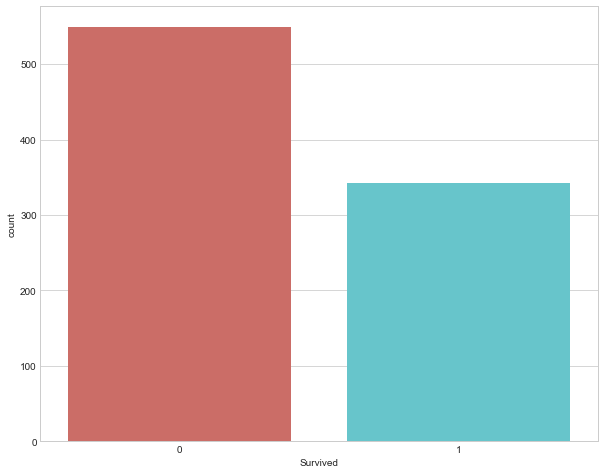

In [6]:
#Check that the target variable is Binary

sns.countplot(x='Survived', data=titanic, palette='hls')

In [7]:
#Check for missing values

titanic.isnull().sum() 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
#Nearly all the Cabin values are missing, so I should drop that variable
#PassengerId, Name, and Ticket - probably have no affect on survival

#AGE is likely an important variable, but 177 values are missing

In [9]:
titanic_data = titanic.drop(['PassengerId', 'Cabin', 'Ticket', 'Name'], 1)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [10]:
#Impute Missing Values

#Take a look at how Age and Passenger Class are related

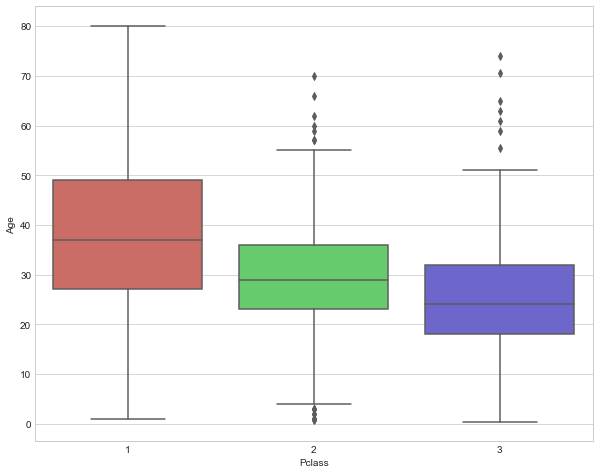

In [11]:
sns.boxplot(x='Pclass', y='Age', data=titanic_data, palette='hls')

In [12]:
#OBSERVATIONS - generally the younger, the lower the Class
#Could write a function that approximates Age based on Class

#Averages appear to be 37 for 1st, 29 for 2nd, and 24 for 3rd
#Apply these Averages to the Null Values, based on Class

In [13]:
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

In [14]:
#apply this Function - Check for Null values in Age

titanic_data['Age'] = titanic_data[['Age', 'Pclass']].apply(age_approx, axis=1)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [15]:
#NO Nulls in Age - 2 Nulls with Embarked attribute - they can be dropped

titanic_data.dropna(inplace=True)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [16]:
#CONVERT Categorical Variables to DUMMY INDICATORS
#Reformat variables to work with model - Sex and Embarked, to numerical

In [17]:
gender = pd.get_dummies(titanic_data['Sex'], drop_first=True)
gender.head()

,male
0,1
1,0
2,0
3,0
4,1


In [18]:
embark_location = pd.get_dummies(titanic_data['Embarked'], drop_first=True)
embark_location.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [19]:
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [20]:
#DROP Sex and Embarked - CONCATONATE gender and embark_location

titanic_data.drop(['Sex', 'Embarked'], axis=1, inplace=True)
titanic_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [21]:
titanic_dmy = pd.concat([titanic_data, gender, embark_location], axis=1)
titanic_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


In [22]:
#New Dataset, titanic_dmy - has all variables with Numerical values

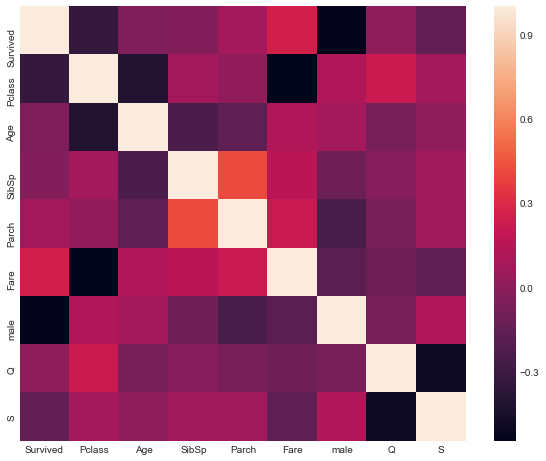

In [23]:
#CHECK for INDEPENDENCE between Features

sns.heatmap(titanic_dmy.corr())

In [24]:
#There is Correlation between Fare and Pclass - they're Not independent
#Drop them

titanic_dmy.drop(['Fare', 'Pclass'], axis=1, inplace=True)
titanic_dmy.head()

,Survived,Age,SibSp,Parch,male,Q,S
0,0,22.0,1,0,1,0,1
1,1,38.0,1,0,0,0,0
2,1,26.0,0,0,0,0,1
3,1,35.0,1,0,0,0,1
4,0,35.0,0,0,1,0,1


In [25]:
#Now 6 non-target Features remain - Some say you should 
#have >=50 records per Feature - we should have at least 300

titanic_dmy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 7 columns):
Survived    889 non-null int64
Age         889 non-null float64
SibSp       889 non-null int64
Parch       889 non-null int64
male        889 non-null uint8
Q           889 non-null uint8
S           889 non-null uint8
dtypes: float64(1), int64(3), uint8(3)
memory usage: 37.3 KB


In [26]:
#time for REGRESSION

In [27]:
X = titanic_dmy.ix[:, (1,2,3,4,5,6)].values
Y = titanic_dmy.ix[:, 0].values

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state = 0)

In [49]:
#Deploy Model - Evaluate Fit

LogReg = LogisticRegression()
LogReg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [50]:
Y_pred = LogReg.predict(X_test)

In [51]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_pred, Y_test)

0.7677902621722846

In [33]:
#the Accuracy of the Model - 76.78 % 

array([[132,  37],
       [ 25,  73]])

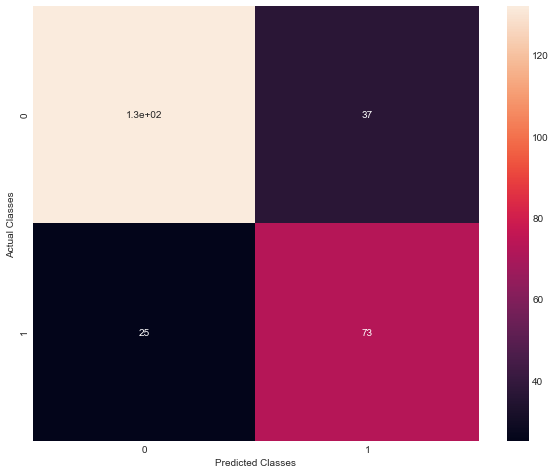

In [52]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_pred, Y_test)
sns.heatmap(confusion_matrix, annot=True)
plt.xlabel('Predicted Classes')
plt.ylabel('Actual Classes')
confusion_matrix

In [53]:
#the Confusion Matrix shows - 132 and 73 correct predictions - 25 and 37 incorrect

#132 times the model correctly predicted Class 0 when the Actual Class was 0 

In [54]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

             precision    recall  f1-score   support

          0       0.78      0.84      0.81       157
          1       0.74      0.66      0.70       110

avg / total       0.77      0.77      0.77       267



In [55]:
#above notes from Lillian Pierson - Logistic Regression example in python

In [56]:
#below notes from Animesh Agarwal - Logistic Regression classifier on Census
#Income Data

In [57]:
#CROSS-VALIDATION with StratifiedKFold

from sklearn.model_selection import cross_val_score

cross_val_model = LogisticRegression(random_state=0)
scores = cross_val_score(cross_val_model, X_train, Y_train, cv=5)
print(np.mean(scores))

0.7974451612903226


In [58]:
#the Accuracy with Cross-Validation is 79.74 %  -  our model was 76.78 %

In [59]:
#we can FINE-TUNE our Model  -  play w Parameters  -  and use GridSearchCV


# penalty specifies the norm in the penalization
penalty = ['l1', 'l2']

# C is the inverse of the regularization parameter
C = np.logspace(0, 4, 10)

random_state = [0]

# create a Dictionary of Hyperparameters
hyperparameters = dict(C=C, penalty=penalty, random_state=random_state)

In [60]:
#use GridSearchCV  -  find Optimal Parameters

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(estimator = LogReg, param_grid = hyperparameters, cv=5)
best_model = clf.fit(X_train, Y_train)
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 1.0


In [61]:
# Predict using the Best Model (your model w these new Parameters) 

best_predicted_values = best_model.predict(X_test)
accuracy_score(best_predicted_values, Y_test)

0.7677902621722846

In [62]:
# I received the same Accuracy Score as before - maybe change C, penalty?

# I received slightly higher Accuracy Scores by raising the random_state

# You could save this model for future use, rather than re-training, w Pickle